<a href="https://colab.research.google.com/github/ipinmi/mpl_tasks/blob/main/CLIP_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

generate captions and then retrain over a lora layer

test on lxmert and a generative model

attention based on different number of people

## testing

In [2]:
## testing

from transformers import ViltProcessor, ViltForImagesAndTextClassification
import requests
from PIL import Image

image1 = Image.open(requests.get("https://lil.nlp.cornell.edu/nlvr/exs/ex0_0.jpg", stream=True).raw)
image2 = Image.open(requests.get("https://lil.nlp.cornell.edu/nlvr/exs/ex0_1.jpg", stream=True).raw)
text = "The left image contains twice the number of dogs as the right image."

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-nlvr2")
model = ViltForImagesAndTextClassification.from_pretrained("dandelin/vilt-b32-finetuned-nlvr2")

# prepare inputs
encoding = processor([image1, image2], text, return_tensors="pt")

# forward pass
outputs = model(input_ids=encoding.input_ids, pixel_values=encoding.pixel_values.unsqueeze(0))
logits = outputs.logits
idx = logits.argmax(-1).item()
print("Predicted answer:", model.config.id2label[idx])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/797 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/456M [00:00<?, ?B/s]

Predicted answer: True


# **CLIP Explainability**

In [3]:
!git clone https://github.com/hila-chefer/Transformer-MM-Explainability

import os
os.chdir(f'./Transformer-MM-Explainability')

!pip install einops
!pip install ftfy
!pip install captum

fatal: destination path 'Transformer-MM-Explainability' already exists and is not an empty directory.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **CLIP**

In [4]:
import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization

In [5]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}

In [6]:
def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1:
      # calculate index of last layer
      start_layer = len(image_attn_blocks) - 1

    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]


    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1:
      # calculate index of last layer
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text

    return text_relevance, image_relevance

In [7]:
def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

In [28]:
def show_image_with_bounding_boxes(image_relevance, image, orig_image, threshold=0.5):
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    binary_mask = (image_relevance > threshold).astype(np.uint8)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]

    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    for (x, y, w, h) in bounding_boxes:
        cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image)
    axs[0].axis('off')
    axs[1].imshow(vis)
    axs[1].axis('off')
    plt.show()


In [43]:
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)
  R_text = R_text[CLS_idx, 1:CLS_idx]
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()
  print(text_scores)
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)

In [9]:
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
}

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [11]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [12]:
images_path = ['3031_HANSEL_GRETEL_WITCH_HUNTERS_00.04.24.171-00.04.27.384@0.jpg',
 '3036_IN_TIME_00.31.36.495-00.31.38.778@0.jpg',
 '3005_ABRAHAM_LINCOLN_VAMPIRE_HUNTER_01.32.36.155-01.32.46.111@0.jpg',
 '0010_Frau_Ohne_Gewissen_01.40.35.924-01.40.38.321@0.jpg',
 '3088_WHATS_YOUR_NUMBER_00.04.36.821-00.04.38.295@0.jpg',
 '0050_Indiana_Jones_and_the_last_crusade_01.10.13.138-01.10.31.495@6.jpg']

 # 0,3,0,3,2,3,

In [62]:
questions = [
    [
        "What is Casey using bowl for ? To cook the siblings .",
        "What is Casey using bowl for ? Casey is used for decorative purposes .",
        "What is Casey using bowl for ? Casey is putting an ice cube in bowl .",
        "What is Casey using bowl for ? Casey is cooking with bowl .",
    ],
    [
        "What would Casey probably do with wineglass ? Casey will pour a liquor into the glass .",
        "What would Casey probably do with wineglass ? Casey would place wineglass back up on the platform .",
        "What would Casey probably do with wineglass ? If wineglass was empty Casey would pour wineglass into wineglass .",
        "What would Casey probably do with wineglass ? Casey will drink out of wineglass .",
    ],
    [
        "What would happen if Riley walked towards Casey ? Casey would ignore Riley .",
        "What would happen if Riley walked towards Casey ? Casey would start to talk with Kerry .",
        "What would happen if Riley walked towards Casey ? Casey would be surprised and frightened .",
        "What would happen if Riley walked towards Casey ? Riley wouldn ' t even notice .",
    ],
    [
        "What is Casey doing with Riley ? Casey is carrying Riley to the couch .",
        "What is Casey doing with Riley ? They are helping Riley get off of a bus .",
        "What is Casey doing with Riley ? Riley and Casey decided to dance .",
        "What is Casey doing with Riley ? Casey is letting Riley into the office .",
    ],
    [
        "Why has Casey stopped walking ? Casey is looking at something .",
        "Why has Casey stopped walking ? Casey has a need to have a conversation with Riley .",
        "Why has Casey stopped walking ? Casey is at a traffic stop with Riley .",
        "Why has Casey stopped walking ? Casey is waiting to cross the street .",
    ],
    [
        "What is Riley doing ? Peyton is talking with Riley .",
        "What is Riley doing ? Jessie is talking on phone .",
        "What is Riley doing ? Riley is looking at a book and pointing out something .",
        "What is Riley doing ? Jaime is guiding people , protecting a dangerous location .",
    ],
]

### viz

In [17]:
import os
source_directory = "/content/drive/MyDrive/viz_images"

In [57]:
img_path = os.path.join(source_directory, images_path[1])
img_path

'/content/drive/MyDrive/viz_images/3036_IN_TIME_00.31.36.495-00.31.38.778@0.jpg'

tensor([0.0138, 0.0003, 0.1144, 0.0825, 0.1711, 0.0855, 0.0093, 0.0102, 0.0118,
        0.2004, 0.1794, 0.1216], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,why has casey stopped walking ? casey is looking at something .


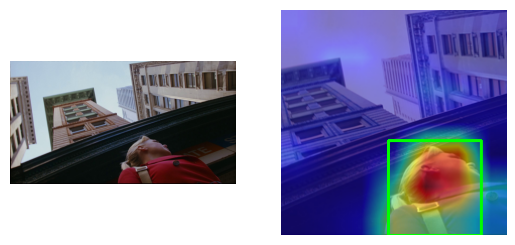

tensor([3.0457e-02, 1.7967e-03, 3.0322e-01, 9.1064e-02, 1.4819e-01, 9.3872e-02,
        3.6987e-02, 1.6983e-02, 4.6959e-03, 5.7617e-02, 2.4796e-04, 9.1553e-03,
        2.5673e-03, 9.4238e-02, 2.8419e-03, 9.2651e-02, 1.3336e-02],
       device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,why has casey stopped walking ? casey has a need to have a conversation with riley .


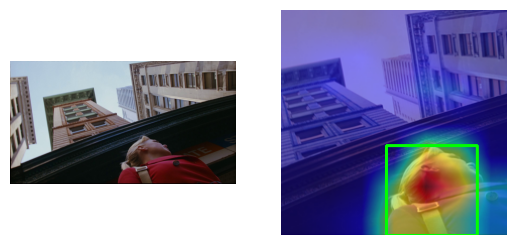

tensor([1.4755e-02, 1.7917e-04, 3.2153e-01, 4.8737e-02, 1.4563e-01, 9.4116e-02,
        3.3875e-02, 1.5457e-02, 6.6185e-03, 1.3790e-03, 2.0361e-01, 2.6001e-02,
        3.9032e-02, 5.0888e-03, 4.4067e-02], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,why has casey stopped walking ? casey is at a traffic stop with riley .


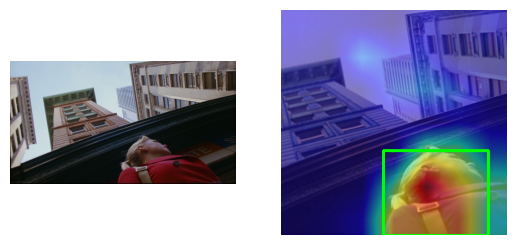

tensor([0.0056, 0.0004, 0.1204, 0.0731, 0.1414, 0.0588, 0.0115, 0.0227, 0.1216,
        0.0324, 0.0763, 0.0045, 0.1637, 0.1680], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,why has casey stopped walking ? casey is waiting to cross the street .


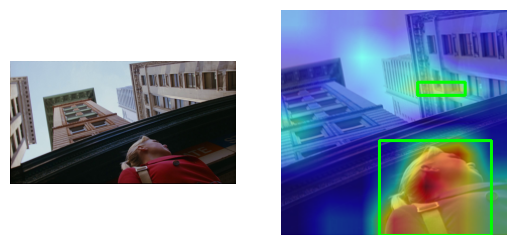

In [63]:

#3 objects
i = 4
img_path = os.path.join(source_directory, images_path[i])
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = questions[i]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_with_bounding_boxes(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

tensor([0.0095, 0.0236, 0.2815, 0.0109, 0.0040, 0.0092, 0.0242, 0.0067, 0.0030,
        0.1628, 0.0290, 0.0632, 0.0089, 0.0516, 0.0006, 0.0058, 0.2445, 0.0605],
       device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,what would casey probably do with wine glass ? casey will pour a liquor into the glass .


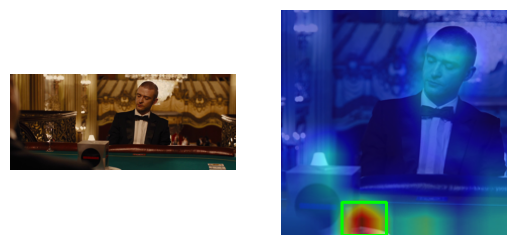

tensor([0.0085, 0.0328, 0.3438, 0.0182, 0.0051, 0.0151, 0.0222, 0.0873, 0.0434,
        0.1770, 0.0090, 0.0389, 0.0240, 0.0245, 0.0082, 0.0335, 0.0054, 0.0070,
        0.0765, 0.0197], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,what would casey probably do with wine glass ? casey would place wine glass back up on the platform .


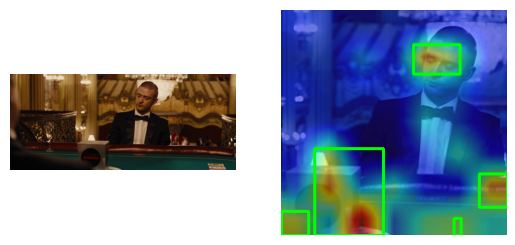

tensor([1.2314e-02, 3.6530e-02, 4.0015e-01, 1.4084e-02, 6.3019e-03, 9.9869e-03,
        1.5358e-02, 3.3607e-03, 8.2703e-03, 6.4125e-03, 1.2337e-02, 1.8723e-02,
        1.3089e-04, 8.2031e-02, 2.4768e-01, 1.6983e-02, 5.7892e-02, 1.1528e-02,
        0.0000e+00, 2.1229e-03, 1.3794e-02, 2.2644e-02, 1.3237e-03],
       device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,what would casey probably do with wine glass ? if wine glass was empty casey would pour wine glass into wine glass .


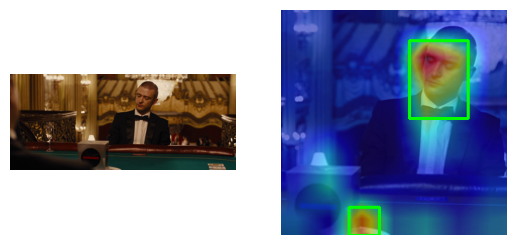

tensor([0.0171, 0.0311, 0.3638, 0.0156, 0.0086, 0.0130, 0.0278, 0.0161, 0.0145,
        0.2352, 0.0460, 0.0239, 0.0385, 0.0217, 0.0283, 0.0812, 0.0174],
       device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,what would casey probably do with wine glass ? casey will drink out of wine glass .


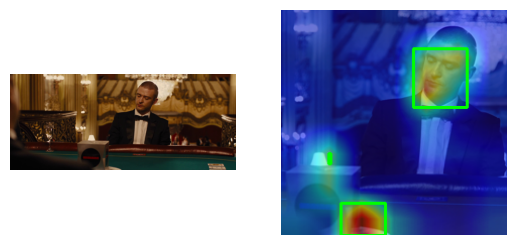

In [58]:
#5 objects
i = 1
img_path = os.path.join(source_directory, images_path[i])
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = questions[i]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_with_bounding_boxes(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

tensor([0.0219, 0.0244, 0.4500, 0.0385, 0.1543, 0.0685, 0.0332, 0.0550, 0.0045,
        0.1116, 0.0381], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,what is riley doing ? peyton is talking with riley .


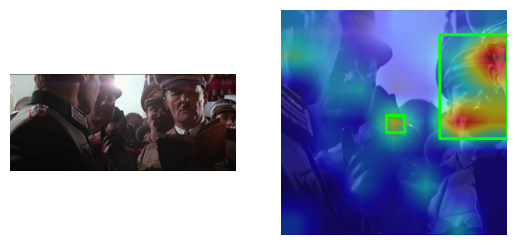

tensor([0.0178, 0.0133, 0.3433, 0.0175, 0.1024, 0.3474, 0.0241, 0.0218, 0.0139,
        0.0366, 0.0622], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,what is riley doing ? jessie is talking on phone .


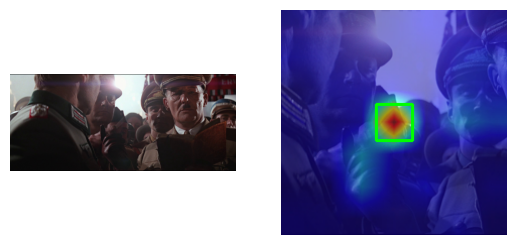

tensor([0.0171, 0.0072, 0.2976, 0.0224, 0.0831, 0.0591, 0.0212, 0.0068, 0.0447,
        0.0024, 0.0320, 0.0395, 0.1783, 0.0641, 0.0193, 0.1053],
       device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,what is riley doing ? riley is looking at a book and pointing out something .


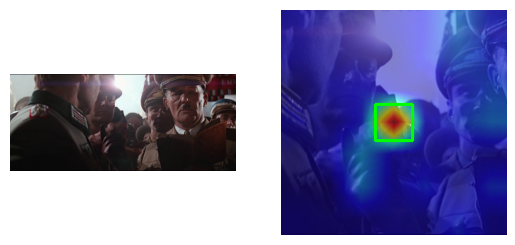

tensor([0.0104, 0.0076, 0.1648, 0.0180, 0.0602, 0.2238, 0.0409, 0.0747, 0.1190,
        0.1119, 0.0291, 0.0067, 0.0222, 0.0450, 0.0659], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"what is riley doing ? jaime is guiding people , protecting a dangerous location ."


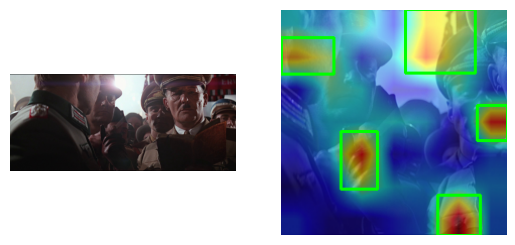

In [54]:
#10 objects
i = 5
img_path = os.path.join(source_directory, images_path[i])
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = questions[i]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_with_bounding_boxes(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

# ViLT

In [64]:
from transformers import ViltProcessor, ViltForImagesAndTextClassification
import requests
from PIL import Image

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-nlvr2")
model = ViltForImagesAndTextClassification.from_pretrained("dandelin/vilt-b32-finetuned-nlvr2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/797 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/456M [00:00<?, ?B/s]

In [76]:
from transformers import ViltProcessor, ViltForImageAndTextRetrieval
import requests
from PIL import Image

image = Image.open(os.path.join(source_directory, images_path[5]))
texts = questions[5]

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-coco")
model = ViltForImageAndTextRetrieval.from_pretrained("dandelin/vilt-b32-finetuned-coco")

# forward pass
scores = dict()
for text in texts:
    # prepare inputs
    encoding = processor(image, text, return_tensors="pt")
    outputs = model(**encoding)
    scores[text] = outputs.logits[0, :].item()

In [78]:
scores

{'What is Riley doing ? Peyton is talking with Riley .': -1.614705204963684,
 'What is Riley doing ? Jessie is talking on phone .': -3.465092658996582,
 'What is Riley doing ? Riley is looking at a book and pointing out something .': -8.111196517944336,
 'What is Riley doing ? Jaime is guiding people , protecting a dangerous location .': -2.185269832611084}

# Examples of biased similarity scores (noise scores higher than dog)

CLIP similarity score: 26.96875
tensor([0.0317, 0.3079, 0.0706, 0.0163, 0.5732], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an image of a dog


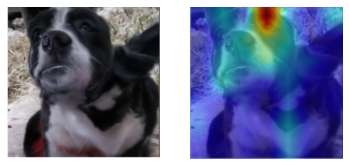

In [ ]:
img_path = "CLIP/dog.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["an image of a dog"]
text = clip.tokenize(texts).to(device)
logits_per_image, logits_per_text = model(img, text)
print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {logits_per_image.item()}' + color.END)
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

CLIP similarity score: 28.71875
tensor([0.0592, 0.3030, 0.4734, 0.0612, 0.1031], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an image of a dog


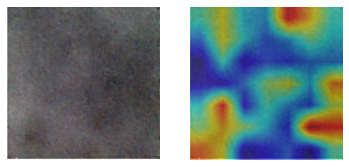

In [ ]:
img_path = "CLIP/noise.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["an image of a dog"]
text = clip.tokenize(texts).to(device)
logits_per_image, logits_per_text = model(img, text)
print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {logits_per_image.item()}' + color.END)
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()